# Imports

In [1]:
!pip install split-folders

In [67]:
import warnings
from keras import models
warnings.filterwarnings("ignore")
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from sklearn.metrics import classification_report
from tensorflow.keras import layers
import os
import seaborn as sns
from collections import Counter
from keras import backend as K
plt.style.use("ggplot")
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
import glob
from pathlib import Path
import cv2
import shutil
import splitfolders
from sklearn.metrics import accuracy_score, classification_report
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from keras.applications import VGG16

# Functions

In [3]:
def plt_show(image, axis = True):
    img = plt.imread(image)
    plt.imshow(img)
    if axis == False: 
        plt.axis("off");
    print(img.shape)
    return img

# PreProcessing

(150, 150, 3)


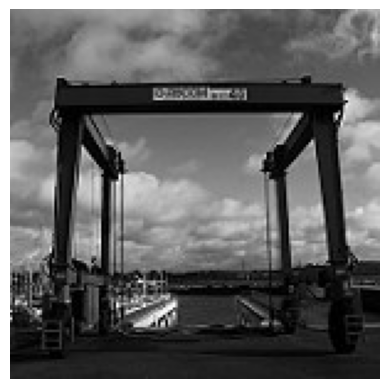

In [4]:
img = plt_show("/kaggle/input/intel-image-classification/seg_train/seg_train/sea/1.jpg", axis = False)

In [5]:
# Split training folder to train Folder & validation Folder
splitfolders.ratio('/kaggle/input/intel-image-classification/seg_train/seg_train', output="output", seed=1337, ratio=(0.8, 0.2)) 

Copying files: 14034 files [02:20, 99.68 files/s] 


In [46]:
val_test_gen = ImageDataGenerator(rescale = 1.0 / 255)

train_generator = val_test_gen.flow_from_directory(
    "/kaggle/working/output/train",
    batch_size = 32,
    target_size = (150,150),
    class_mode = "categorical"
)
validation_generator = val_test_gen.flow_from_directory(
    "/kaggle/working/output/val",
    batch_size = 32,
    target_size = (150,150),
    class_mode = "categorical"
)

test_generator = val_test_gen.flow_from_directory(
        "/kaggle/input/intel-image-classification/seg_test/seg_test",
        target_size=(150, 150),
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

Found 11224 images belonging to 6 classes.
Found 2810 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


# Data Visualization

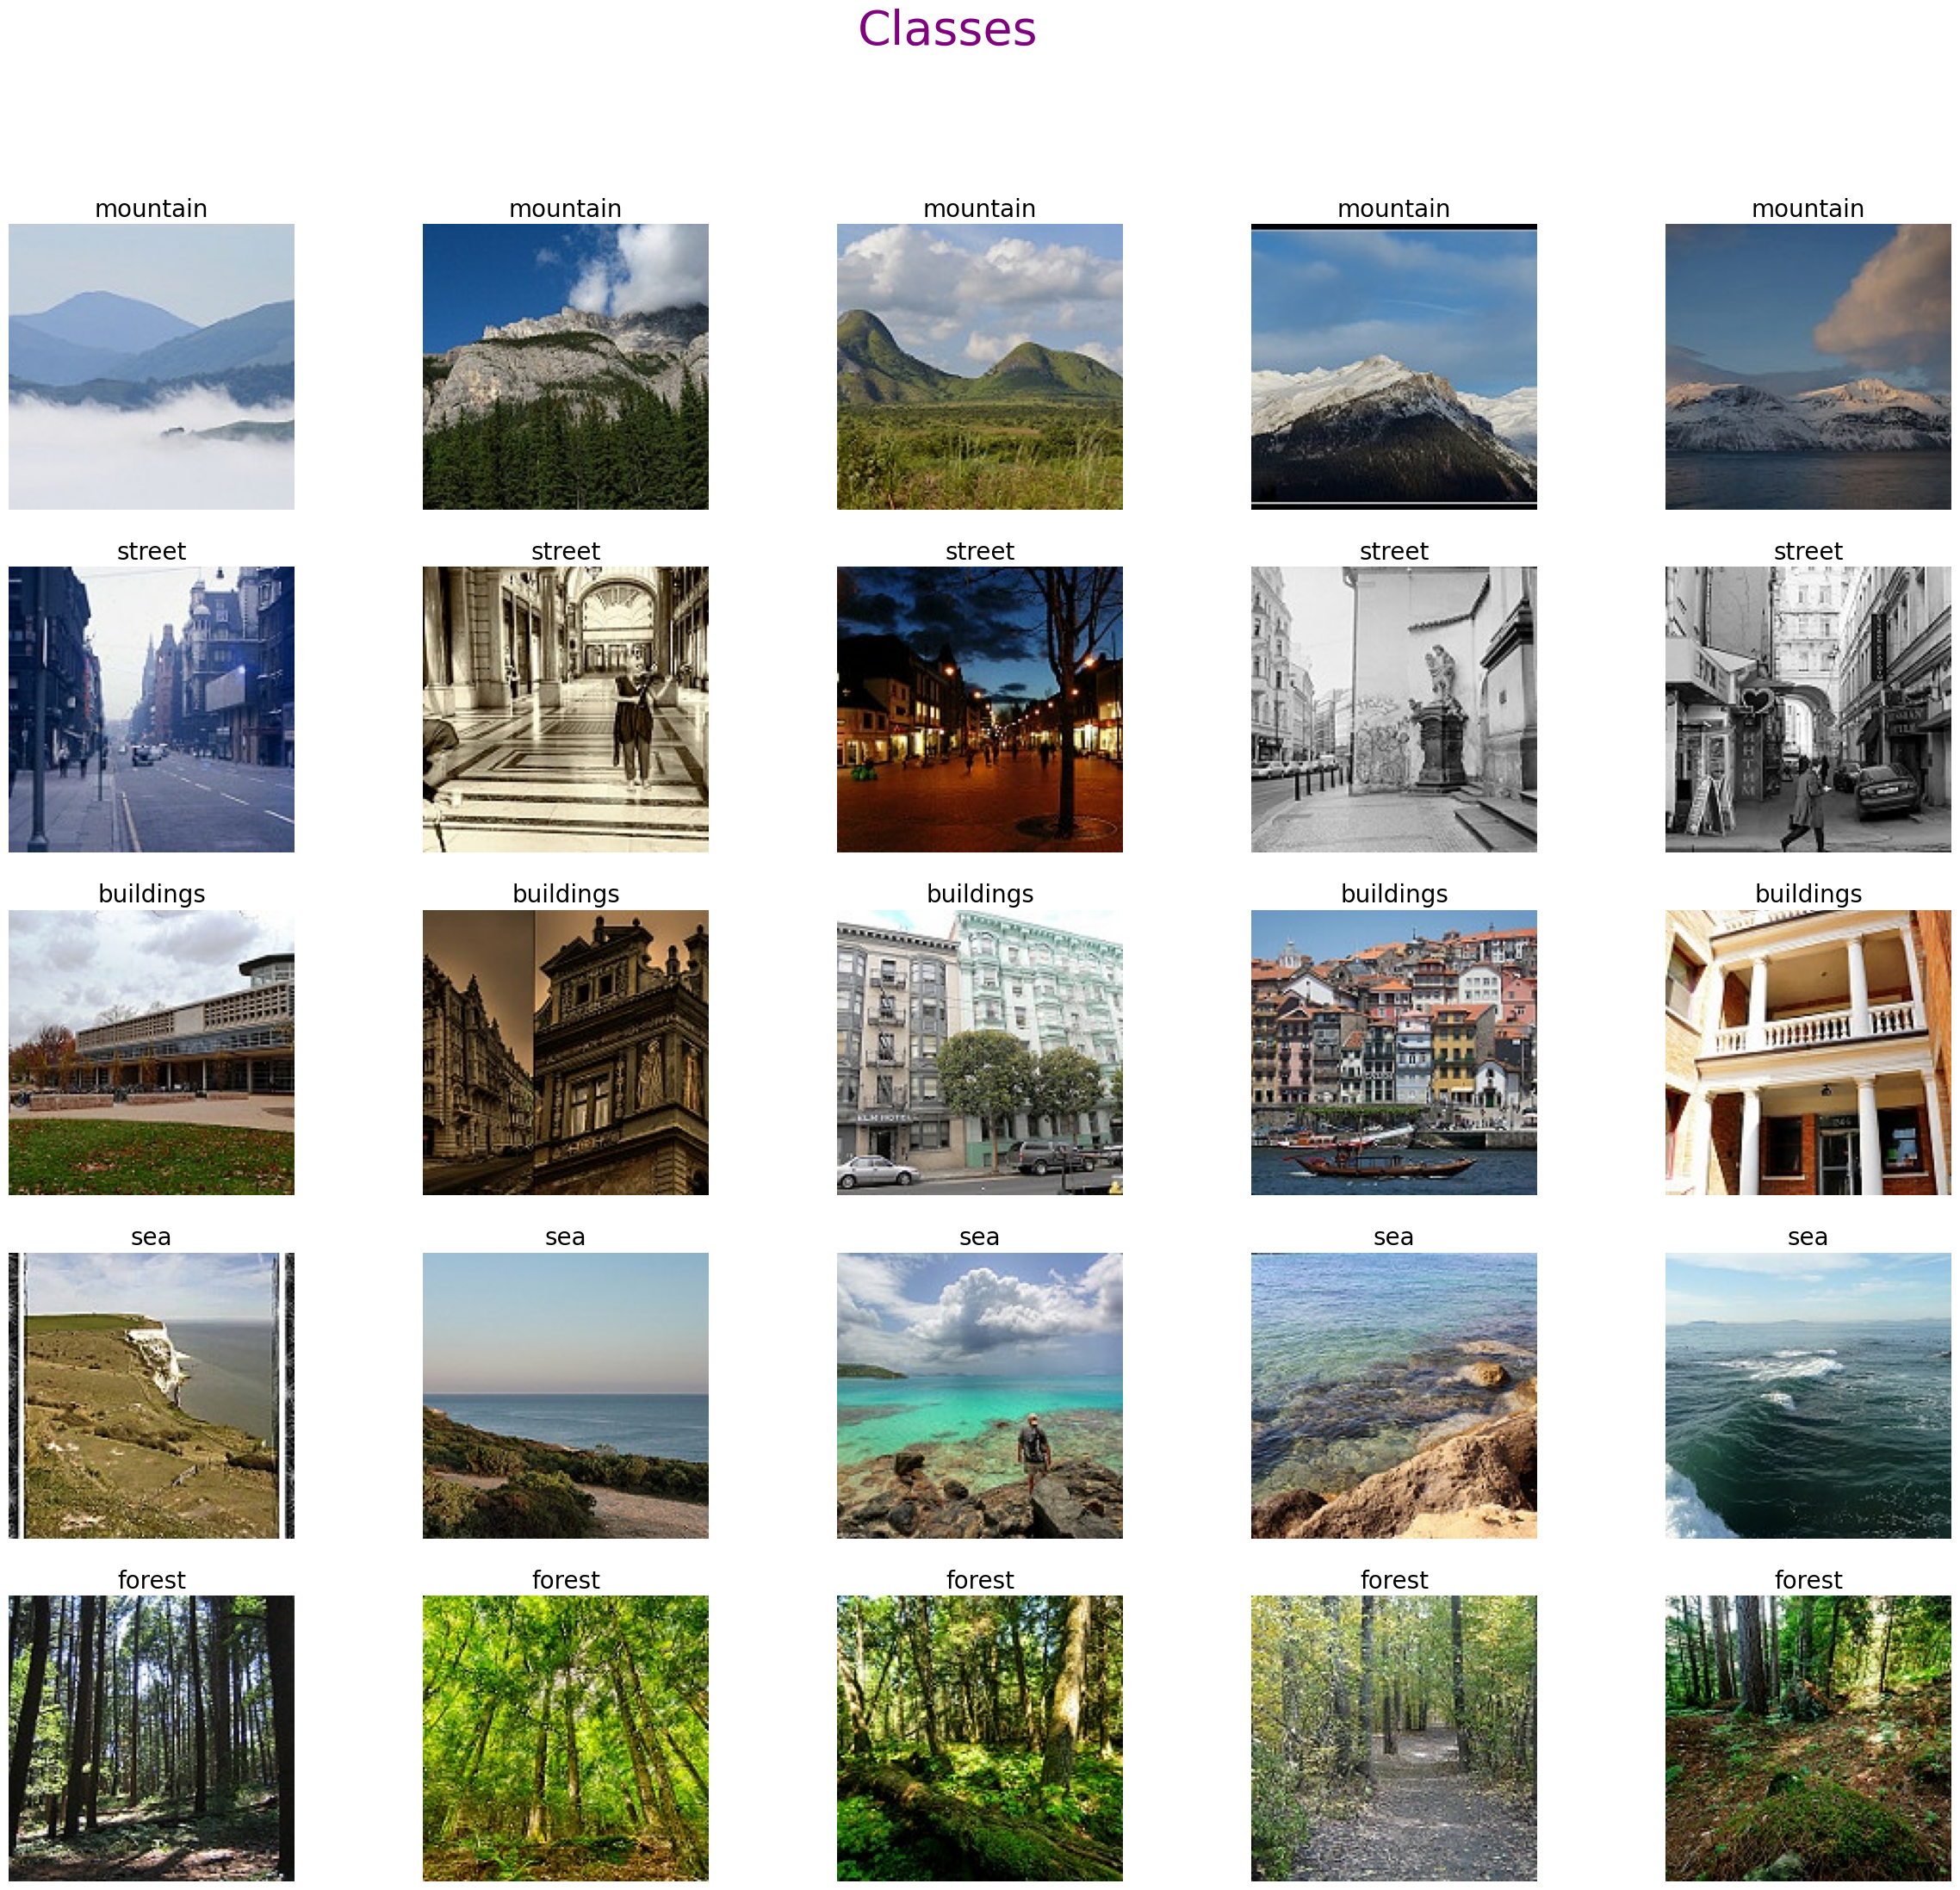

In [47]:
path = '/kaggle/input/intel-image-classification/'
class_names = os.listdir("/kaggle/input/intel-image-classification/seg_train/seg_train")

fig, ax = plt.subplots(5, 5, figsize=(30, 25))
fig.suptitle('Classes', color='purple', fontsize=40)

for ax_row, class_name in zip(ax, class_names[:6]):
    im_src = os.path.join(path, 'seg_train/seg_train', class_name)
    file_names = os.listdir(im_src)
    
    for ax_col, file_name in zip(ax_row, file_names[:5]):
        im_src_file = os.path.join(im_src, file_name)
        image = plt.imread(im_src_file)
        ax_col.axis("off")
        ax_col.imshow(image)
        ax_col.set_title(class_name, fontsize=20)

plt.show()

# Baseline Model

In [48]:
input_size = 150
model = tf.keras.Sequential([
    layers.Conv2D(input_shape=(input_size,input_size,3),filters = 32,kernel_size=(3,3),padding = 'same',activation='relu'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters= 64,kernel_size=(3,3),activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters = 64,kernel_size=(3,3),activation='relu',padding='same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters = 128,kernel_size=(3,3),activation='relu',padding = 'same'),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters = 256,kernel_size=(3,3),activation='relu',padding = 'same'),
    layers.MaxPool2D(),
    
    layers.Flatten(name='flatten'),
    #layers.Dense(150, activation = 'relu'),
    #layers.Dense(100, activation = 'relu'),
    layers.Dense(6, activation = 'softmax')
    
])

In [49]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_12 (Conv2D)          (None, 37, 37, 64)        36928     
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 18, 18, 64)      

In [50]:
#plot_model(model,show_shapes=True)

In [51]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

In [52]:
history = model.fit(train_generator, steps_per_epoch = 11224 // 32,
                    validation_steps = 2810 // 32,
                    epochs = 15,
                    validation_data = validation_generator)

Epoch 1/15
350/350 [==============================] - 20s 52ms/step - loss: 1.0199 - accuracy: 0.5972 - val_loss: 0.8564 - val_accuracy: 0.6624
Epoch 2/15
350/350 [==============================] - 16s 47ms/step - loss: 0.7133 - accuracy: 0.7360 - val_loss: 0.6316 - val_accuracy: 0.7741
Epoch 3/15
350/350 [==============================] - 18s 51ms/step - loss: 0.5741 - accuracy: 0.7940 - val_loss: 0.5654 - val_accuracy: 0.7981
Epoch 4/15
350/350 [==============================] - 18s 52ms/step - loss: 0.4619 - accuracy: 0.8367 - val_loss: 0.5332 - val_accuracy: 0.8150
Epoch 5/15
350/350 [==============================] - 18s 52ms/step - loss: 0.3886 - accuracy: 0.8603 - val_loss: 0.5098 - val_accuracy: 0.8208
Epoch 6/15
350/350 [==============================] - 18s 52ms/step - loss: 0.3331 - accuracy: 0.8807 - val_loss: 0.5013 - val_accuracy: 0.8323
Epoch 7/15
350/350 [==============================] - 18s 51ms/step - loss: 0.2813 - accuracy: 0.9005 - val_loss: 0.5527 - val_accuracy:

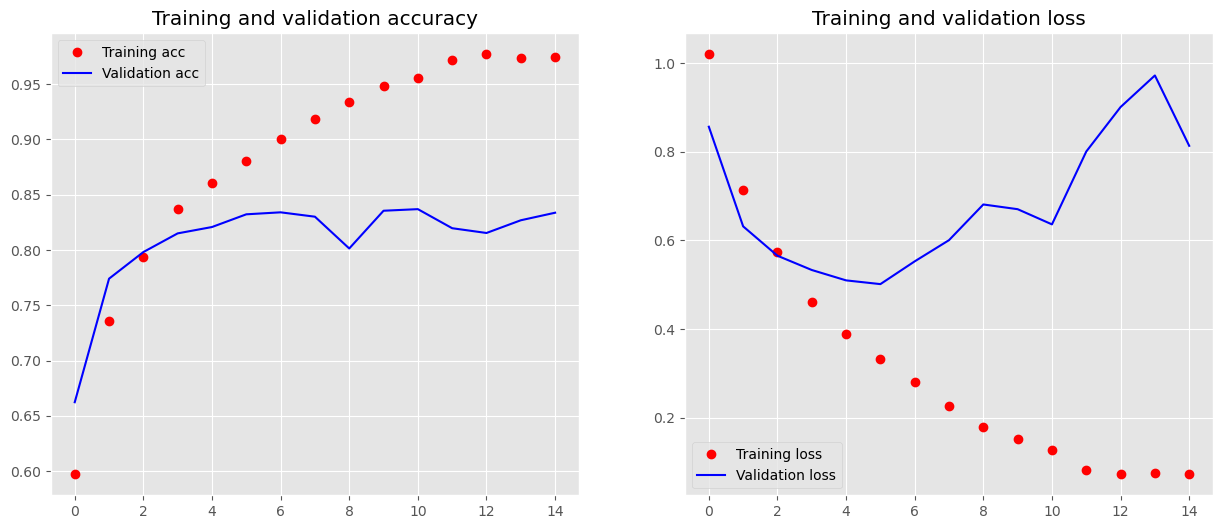

In [58]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6) )
ax[0].plot(epochs, acc, 'ro', label='Training acc')
ax[0].plot(epochs, val_acc, 'b', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'ro', label='Training loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()
plt.show()

In [54]:
y_pred = model.predict(test_generator)
y_pred = [i.argmax() for i in y_pred]
sorted(Counter(y_pred).items())

3000/3000 [==============================] - 10s 3ms/step


[(0, 443), (1, 480), (2, 516), (3, 537), (4, 520), (5, 504)]

In [55]:
y_test = test_generator.classes
sorted(Counter(y_test).items())

[(0, 437), (1, 474), (2, 553), (3, 525), (4, 510), (5, 501)]

In [56]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.81      0.81       437
           1       0.96      0.97      0.96       474
           2       0.79      0.74      0.76       553
           3       0.77      0.78      0.78       525
           4       0.81      0.83      0.82       510
           5       0.85      0.86      0.86       501

    accuracy                           0.83      3000
   macro avg       0.83      0.83      0.83      3000
weighted avg       0.83      0.83      0.83      3000



# Feature Map Visualization

(150, 150, 3)


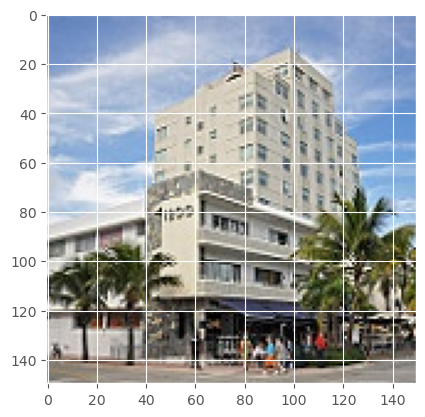

In [61]:
img = plt_show("/kaggle/input/intel-image-classification/seg_train/seg_train/buildings/10032.jpg",axis = "off")
img = img.reshape((1,) + img.shape )

In [64]:
layer_outputs = [layer.output for layer in model.layers[:10]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(img)

1/1 [==============================] - 0s 140ms/step


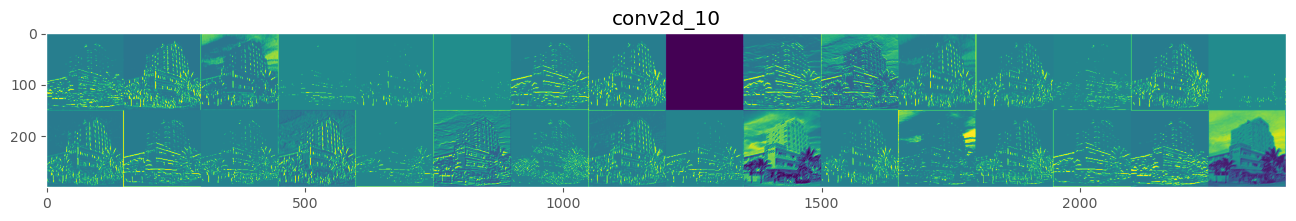

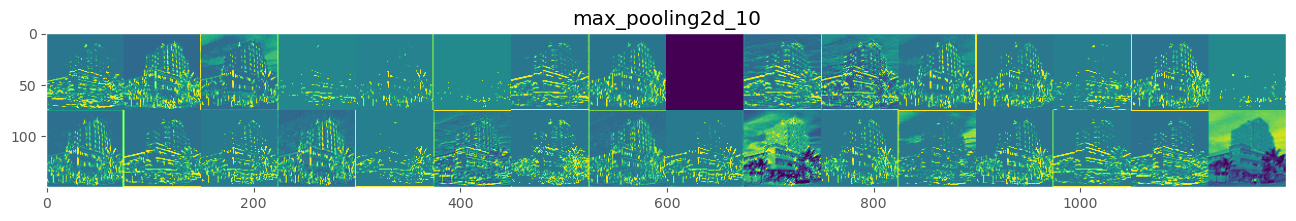

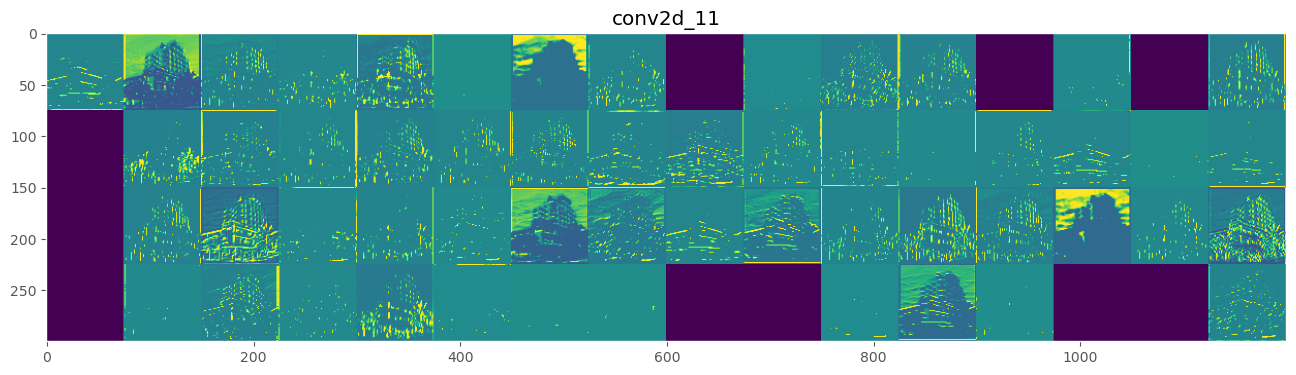

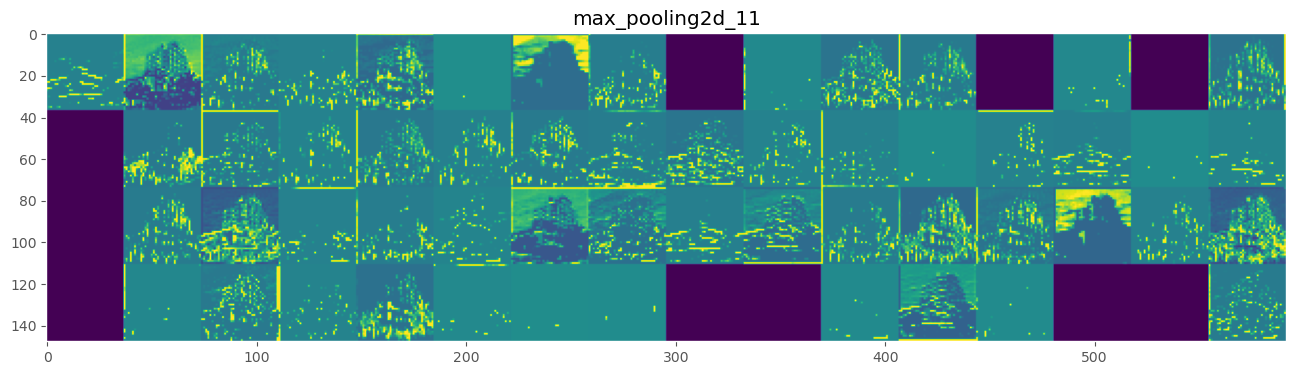

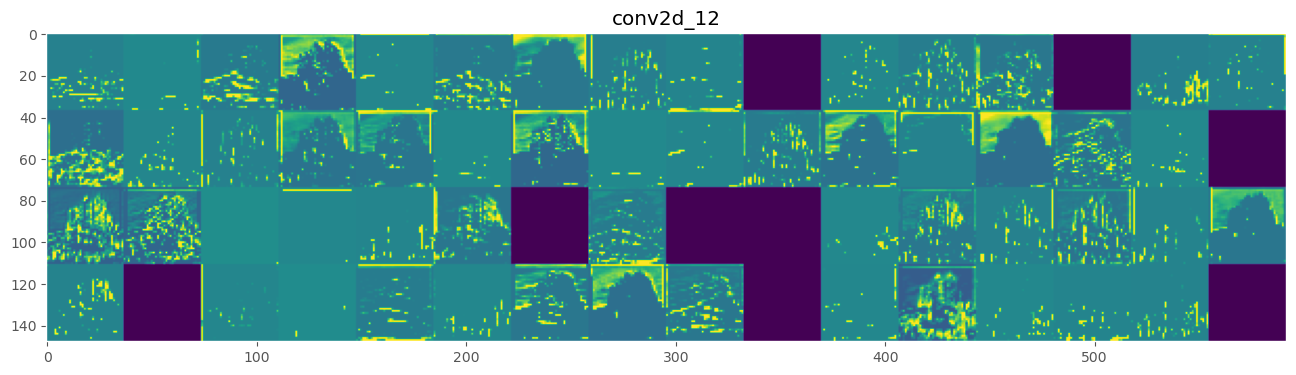

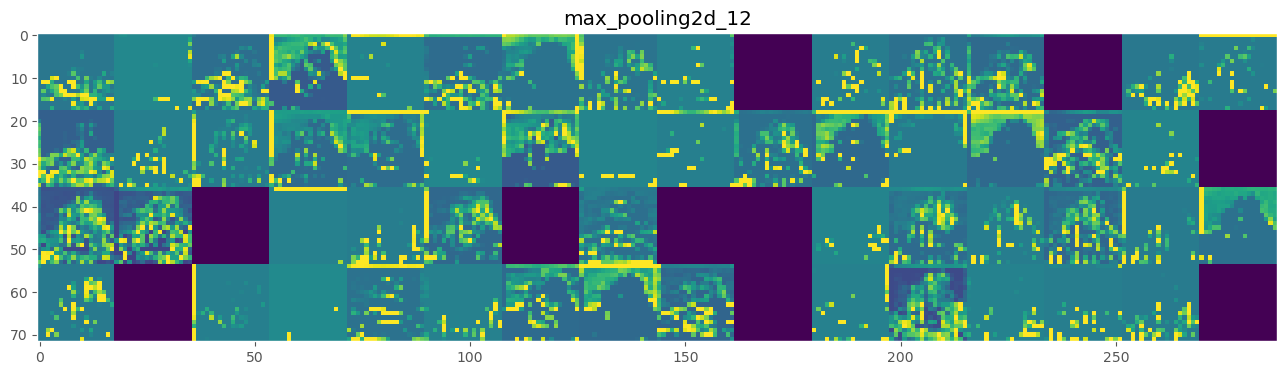

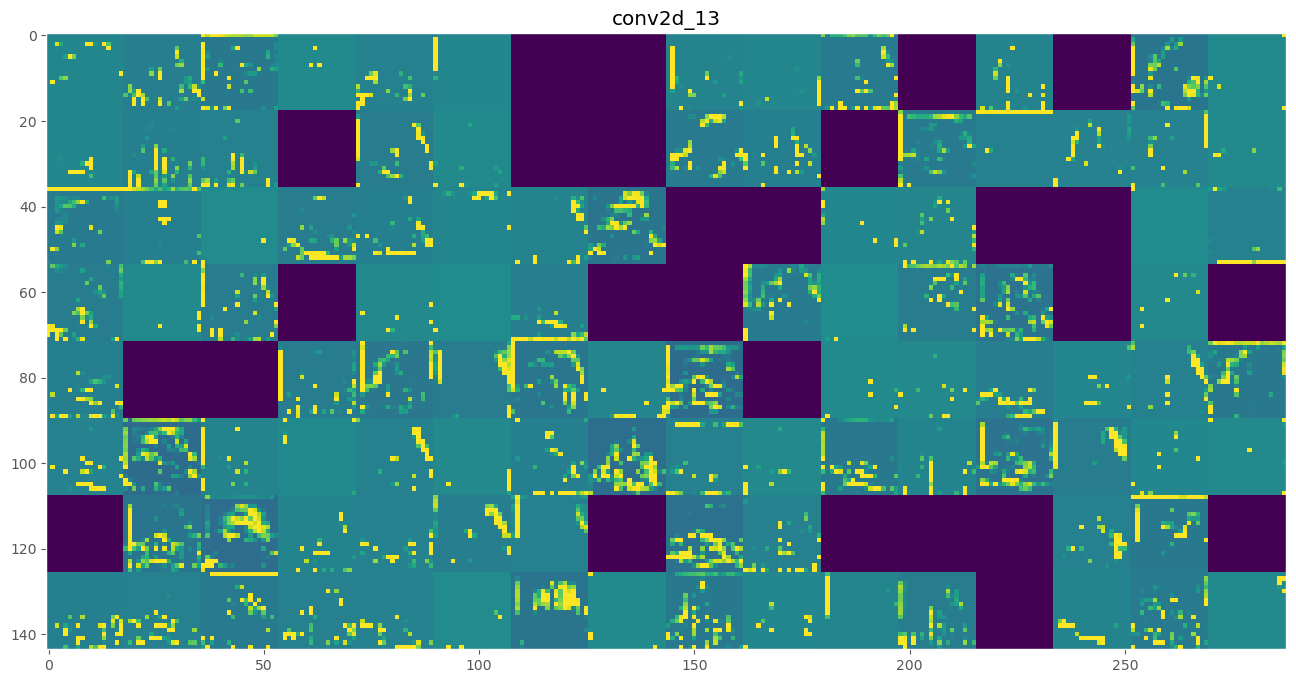

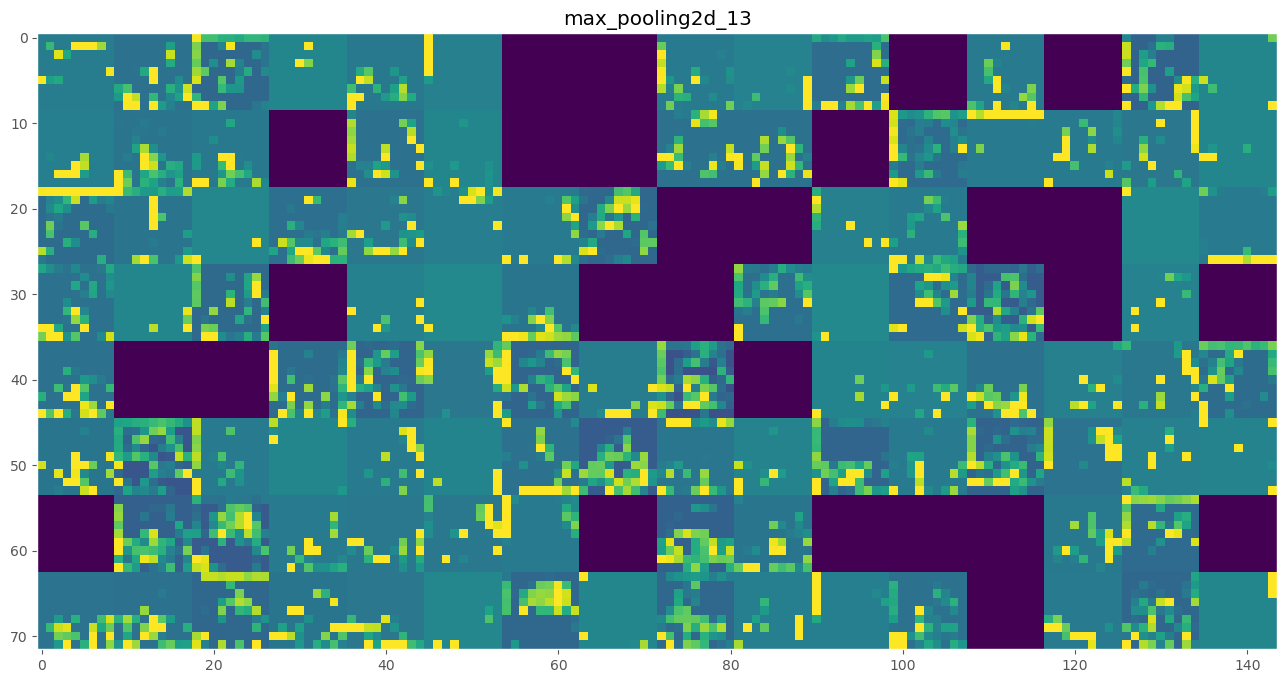

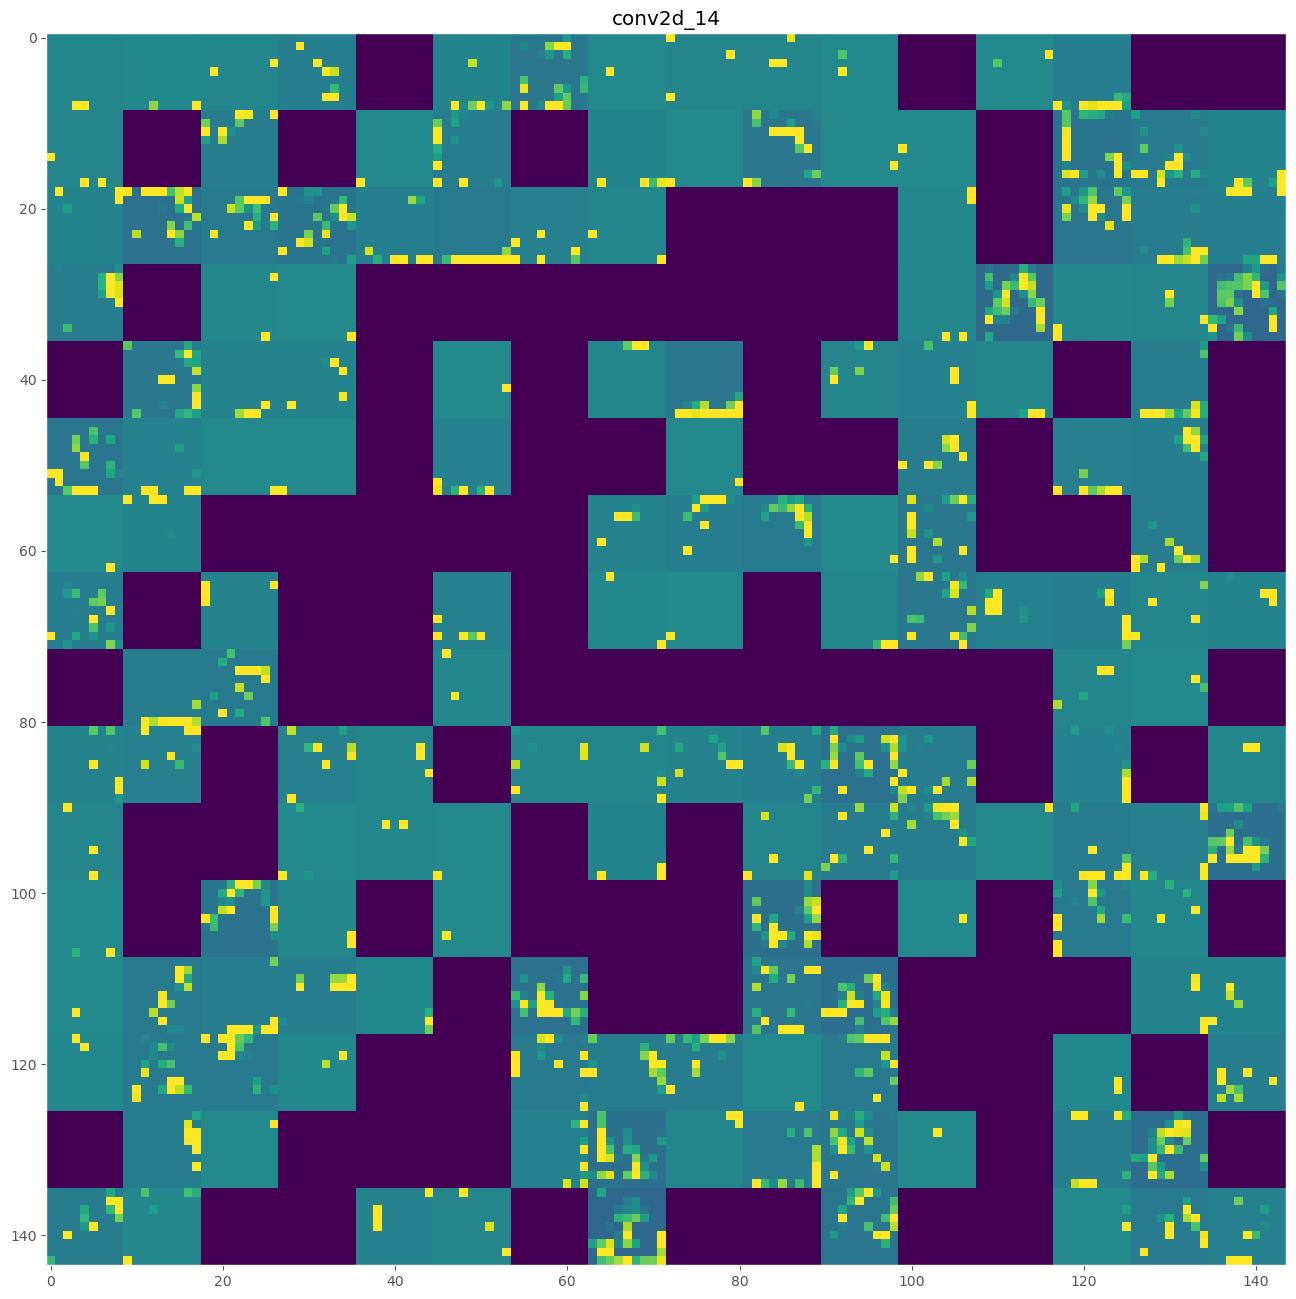

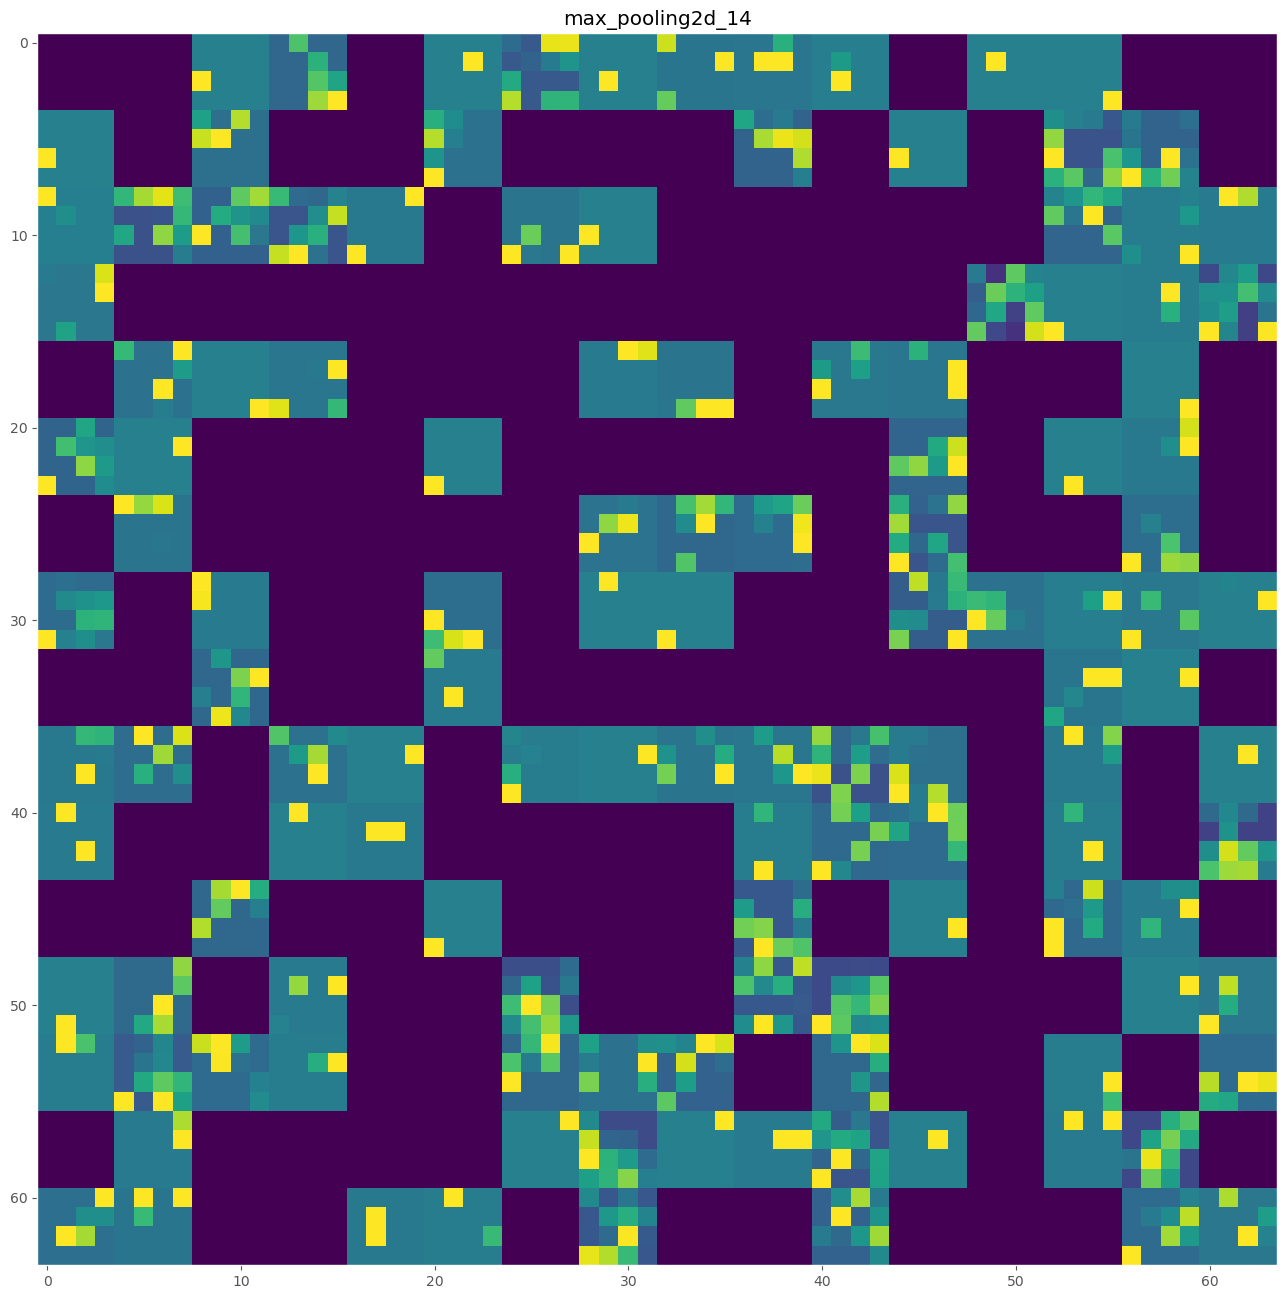

In [65]:
layer_names = [i.name for i in model.layers[:10]]
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]

    size = layer_activation.shape[1]

    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0, :, :, col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')
    
plt.show()

# Using Data augmentation

In [17]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    "/kaggle/working/output/train",
    batch_size = 32,
    target_size = (150,150),
    class_mode = "categorical"
)

validation_generator = val_test_gen.flow_from_directory(
    "/kaggle/working/output/val",
    batch_size = 32,
    target_size = (150,150),
    class_mode = "categorical"
)

Found 11224 images belonging to 6 classes.
Found 2810 images belonging to 6 classes.


In [18]:
history = model.fit(train_generator, steps_per_epoch = 11224 // 32,
                    validation_steps = 2810 // 32,
                    epochs = 15,
                    validation_data = validation_generator)

Epoch 1/15
350/350 [==============================] - 71s 204ms/step - loss: 0.7935 - accuracy: 0.7191 - val_loss: 0.5641 - val_accuracy: 0.8042
Epoch 2/15
350/350 [==============================] - 71s 203ms/step - loss: 0.6552 - accuracy: 0.7659 - val_loss: 0.5246 - val_accuracy: 0.8129
Epoch 3/15
350/350 [==============================] - 69s 197ms/step - loss: 0.6205 - accuracy: 0.7728 - val_loss: 0.5173 - val_accuracy: 0.8154
Epoch 4/15
350/350 [==============================] - 69s 198ms/step - loss: 0.5830 - accuracy: 0.7912 - val_loss: 0.4539 - val_accuracy: 0.8455
Epoch 5/15
350/350 [==============================] - 72s 205ms/step - loss: 0.5650 - accuracy: 0.7966 - val_loss: 0.5210 - val_accuracy: 0.8204
Epoch 6/15
350/350 [==============================] - 72s 205ms/step - loss: 0.5476 - accuracy: 0.8014 - val_loss: 0.6012 - val_accuracy: 0.7874
Epoch 7/15
350/350 [==============================] - 71s 204ms/step - loss: 0.5324 - accuracy: 0.8081 - val_loss: 0.4765 - val_ac

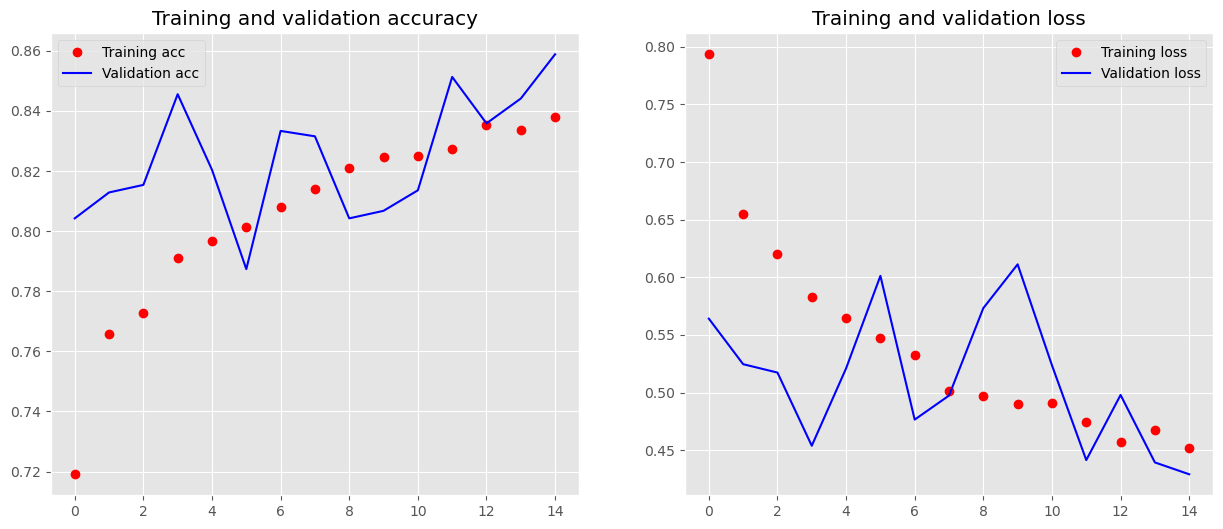

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6) )
ax[0].plot(epochs, acc, 'ro', label='Training acc')
ax[0].plot(epochs, val_acc, 'b', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'ro', label='Training loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()
plt.show()

In [20]:
y_pred = model.predict(test_generator)
y_pred = [i.argmax() for i in y_pred]
sorted(Counter(y_pred).items())

3000/3000 [==============================] - 10s 3ms/step


[(0, 533), (1, 481), (2, 526), (3, 576), (4, 444), (5, 440)]

In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.92      0.83       437
           1       0.97      0.98      0.97       474
           2       0.83      0.79      0.81       553
           3       0.76      0.83      0.79       525
           4       0.91      0.79      0.84       510
           5       0.91      0.80      0.85       501

    accuracy                           0.85      3000
   macro avg       0.86      0.85      0.85      3000
weighted avg       0.86      0.85      0.85      3000



# Using Transfer Learning Without Fine Tuning

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    "/kaggle/working/output/train",
    batch_size = 32,
    target_size = (150,150),
    class_mode = "categorical"
)

validation_generator = val_test_gen.flow_from_directory(
    "/kaggle/working/output/val",
    batch_size = 32,
    target_size = (150,150),
    class_mode = "categorical"
)

Found 11224 images belonging to 6 classes.
Found 2810 images belonging to 6 classes.


In [23]:
conv_base = VGG16(weights = "imagenet", include_top = False, input_shape = (150,150,3))
conv_base.trainable = False
input_size = 150
model = tf.keras.Sequential([
    conv_base,
    layers.Flatten(name='flatten'),
    layers.Dense(150, activation = 'relu'),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(6, activation = 'softmax')
    
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 150)               1228950   
                                                                 
 dense_2 (Dense)             (None, 100)               15100     
                                                                 
 dense_3 (Dense)             (None, 6)                 606       
                                                                 
Total params: 15,959,344
Trainable params: 1,244,656
Non-trainable params: 14,714,688
___________________________________

In [24]:
history = model.fit(train_generator, steps_per_epoch = 11224 // 32,
                    validation_steps = 2810 // 32,
                    epochs = 15,
                    validation_data = validation_generator)

Epoch 1/15
350/350 [==============================] - 88s 239ms/step - loss: 0.6364 - accuracy: 0.7635 - val_loss: 0.4624 - val_accuracy: 0.8247
Epoch 2/15
350/350 [==============================] - 85s 242ms/step - loss: 0.5185 - accuracy: 0.8068 - val_loss: 0.4392 - val_accuracy: 0.8391
Epoch 3/15
350/350 [==============================] - 85s 241ms/step - loss: 0.4865 - accuracy: 0.8141 - val_loss: 0.4205 - val_accuracy: 0.8441
Epoch 4/15
350/350 [==============================] - 80s 229ms/step - loss: 0.4548 - accuracy: 0.8267 - val_loss: 0.4391 - val_accuracy: 0.8434
Epoch 5/15
350/350 [==============================] - 80s 229ms/step - loss: 0.4409 - accuracy: 0.8341 - val_loss: 0.4187 - val_accuracy: 0.8574
Epoch 6/15
350/350 [==============================] - 85s 244ms/step - loss: 0.4305 - accuracy: 0.8397 - val_loss: 0.4681 - val_accuracy: 0.8330
Epoch 7/15
350/350 [==============================] - 87s 247ms/step - loss: 0.4170 - accuracy: 0.8439 - val_loss: 0.3822 - val_ac

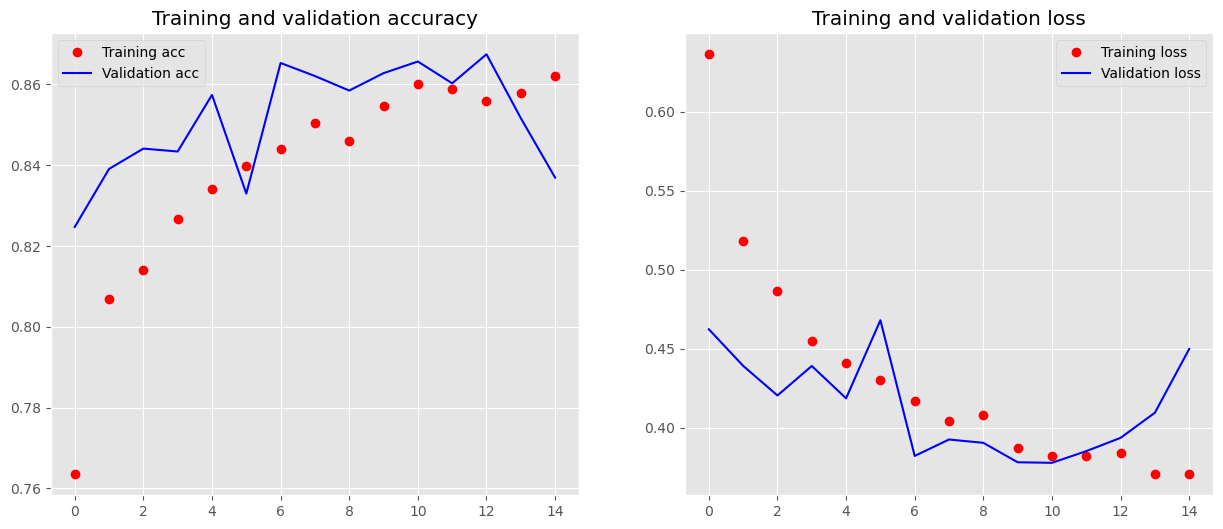

In [25]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6) )
ax[0].plot(epochs, acc, 'ro', label='Training acc')
ax[0].plot(epochs, val_acc, 'b', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'ro', label='Training loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()
plt.show()

In [26]:
y_pred = model.predict(test_generator)
y_pred = [i.argmax() for i in y_pred]
sorted(Counter(y_pred).items())

3000/3000 [==============================] - 21s 7ms/step


[(0, 450), (1, 498), (2, 757), (3, 316), (4, 505), (5, 474)]

In [27]:
model.evaluate(test_generator)

3000/3000 [==============================] - 25s 8ms/step - loss: 0.4103 - accuracy: 0.8470


[0.41027411818504333, 0.847000002861023]

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       437
           1       0.94      0.99      0.96       474
           2       0.67      0.92      0.77       553
           3       0.92      0.55      0.69       525
           4       0.88      0.87      0.87       510
           5       0.92      0.87      0.90       501

    accuracy                           0.85      3000
   macro avg       0.87      0.85      0.85      3000
weighted avg       0.86      0.85      0.84      3000



# TL With Fine Tuning

In [29]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [30]:
conv_base.trainable = True
set_trainable = False
for i in conv_base.layers:
    if i.name == "block5_conv1":
        set_trainable = True
    if set_trainable:
        i.trainable = True
    else:
        i.trainable = False

In [31]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [32]:
model = tf.keras.Sequential([
    conv_base,
    layers.Flatten(name='flatten'),
    layers.Dense(150, activation = 'relu'),
    layers.Dense(100, activation = 'relu'),
    layers.Dense(6, activation = 'softmax')
    
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss = 'categorical_crossentropy',
                metrics = ['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_4 (Dense)             (None, 150)               1228950   
                                                                 
 dense_5 (Dense)             (None, 100)               15100     
                                                                 
 dense_6 (Dense)             (None, 6)                 606       
                                                                 
Total params: 15,959,344
Trainable params: 8,324,080
Non-trainable params: 7,635,264
_________________________________________________________________


In [33]:
history = model.fit(train_generator, steps_per_epoch = 11224 // 32,
                    validation_steps = 2810 // 32,
                    epochs = 15,
                    validation_data = validation_generator)

Epoch 1/15
350/350 [==============================] - 85s 234ms/step - loss: 0.8037 - accuracy: 0.6825 - val_loss: 0.4532 - val_accuracy: 0.8294
Epoch 2/15
350/350 [==============================] - 82s 235ms/step - loss: 0.5243 - accuracy: 0.8176 - val_loss: 0.3946 - val_accuracy: 0.8685
Epoch 3/15
350/350 [==============================] - 82s 235ms/step - loss: 0.4378 - accuracy: 0.8447 - val_loss: 0.3630 - val_accuracy: 0.8768
Epoch 4/15
350/350 [==============================] - 81s 232ms/step - loss: 0.4023 - accuracy: 0.8602 - val_loss: 0.4081 - val_accuracy: 0.8710
Epoch 5/15
350/350 [==============================] - 87s 248ms/step - loss: 0.3840 - accuracy: 0.8659 - val_loss: 0.3398 - val_accuracy: 0.8919
Epoch 6/15
350/350 [==============================] - 82s 233ms/step - loss: 0.3577 - accuracy: 0.8756 - val_loss: 0.3862 - val_accuracy: 0.8693
Epoch 7/15
350/350 [==============================] - 86s 244ms/step - loss: 0.3222 - accuracy: 0.8883 - val_loss: 0.3469 - val_ac

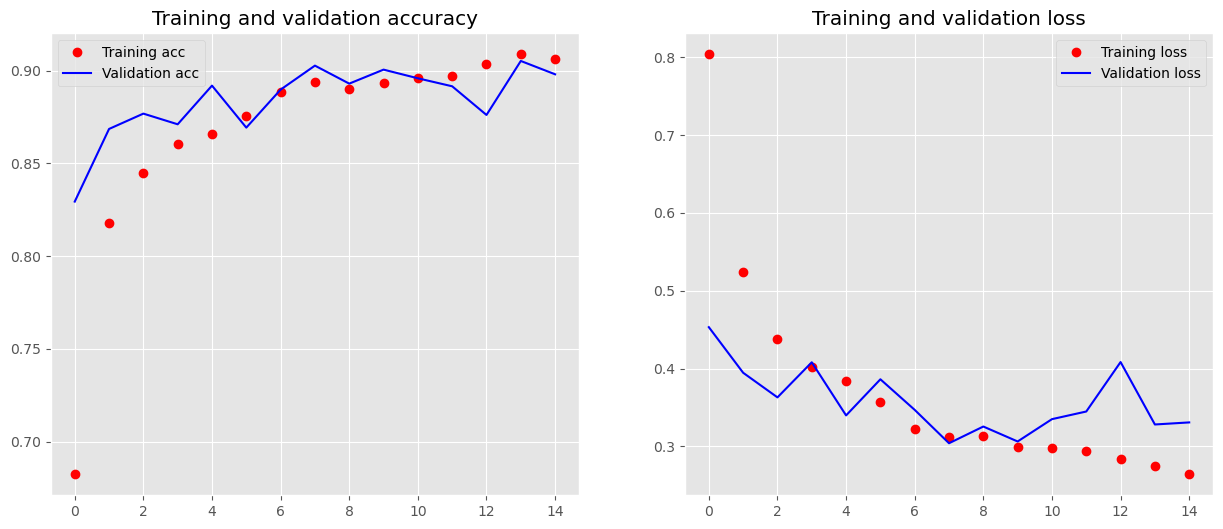

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(15, 6) )
ax[0].plot(epochs, acc, 'ro', label='Training acc')
ax[0].plot(epochs, val_acc, 'b', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

ax[1].plot(epochs, loss, 'ro', label='Training loss')
ax[1].plot(epochs, val_loss, 'b', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()
plt.show()

In [35]:
y_pred = model.predict(test_generator)
y_pred = [i.argmax() for i in y_pred]
sorted(Counter(y_pred).items())
print(classification_report(y_test, y_pred))

3000/3000 [==============================] - 20s 7ms/step
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       437
           1       1.00      0.96      0.98       474
           2       0.86      0.86      0.86       553
           3       0.88      0.84      0.86       525
           4       0.92      0.95      0.93       510
           5       0.87      0.95      0.91       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.90      3000



In [36]:
model.evaluate(test_generator)

3000/3000 [==============================] - 25s 8ms/step - loss: 0.2916 - accuracy: 0.9050


[0.29158955812454224, 0.9049999713897705]